<img src=https://shifthappens.com/wp-content/uploads/2013/08/Martin-Luther-King-I-have-a-dream.jpg width="300" align = "left">
<img src=https://cdn.cnn.com/cnnnext/dam/assets/170428143345-trump-nra-forum-border-wall-easy-one-bts-nr-00005306.jpg width="300" align = "center">
<img src=https://lostinfood.it/wp-content/uploads/2016/11/YES-WE-CAN.jpg width="300" align = "right">

## Introduction

I have a dream. We will build a wall. Yes we can. 

Politicians, leaders, celebrities... they all have a certain appeal to them whether it be their physical or intellectual attributes. We all remember Barack Obama because he instilled a message of hope. We remember him because he was charismatic. We remember him because he was a stepping stone in breaking racial inequity. But what makes inspirational leaders like Barack Obama able to instill this message of hope? What makes him charismatic? 

Using natural language processing (NLP), we hope to explore what makes some people stand out in their speeches. 

## Cleaning

We have a set of transcripts from the Democrat debates leading up to the 2020 election which we will explore and analyze. First, we load the data.

In [1]:
### importing libraries ###

import pandas as pd
import nltk
import matplotlib.pyplot as plt
import seaborn as sns
import string
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import MinMaxScaler
from nltk.corpus import stopwords
from gensim import corpora, models, similarities
from gensim.parsing.preprocessing import preprocess_string

In [2]:
### importing transcripts ###

# encoding needs to be placed because there are nonASCII symbols that will cause an error when loading transcripts
df = pd.read_csv('debate_transcripts.csv', encoding = 'unicode_escape')

# checking to see if it worked
df.head()

,debate_name,debate_section,speaker,speech,speaking_time_seconds
0,New Hampshire Democratic Debate Transcript,Part 1,George S.,"Candidates, welcome. Vice President Biden, the...",18.0
1,New Hampshire Democratic Debate Transcript,Part 1,Joe Biden,"Oh, they didnt miss anything. Its a long rac...",36.0
2,New Hampshire Democratic Debate Transcript,Part 1,George S.,Why are Senator Sanders and Mayor Buttigieg to...,4.0
3,New Hampshire Democratic Debate Transcript,Part 1,Joe Biden,"Well, you know that with regard to Senator San...",41.0
4,New Hampshire Democratic Debate Transcript,Part 1,George S.,"Senator Sanders, let me give you the chance to...",21.0


The dataset has information containing which debate the transcript came from, the part of the debate, the speaker, the transcript, and how long the speech was for. First, we will look to see if there are any missing values.

In [3]:
### searching for null values ###

df.isnull().sum()

debate_name                0
debate_section             0
speaker                    0
speech                     0
speaking_time_seconds    513
dtype: int64

In [4]:
### looking at null rows ###

# creating a boolean mask of nulls
mask = df['speaking_time_seconds'].isnull()

# applying the mask
df[mask]

,debate_name,debate_section,speaker,speech,speaking_time_seconds
153,New Hampshire Democratic Debate Transcript,Part 1,George S.,"We have much more today coming up, but we have...",NaN
322,New Hampshire Democratic Debate Transcript,Part 2,George S.,Candidates. Thank you. Thanks for a great deba...,NaN
669,January Iowa Democratic Debate Transcript,Entire Debate,Wolf Blitzer,"Candidates, thank you very, very much. That co...",NaN
826,December Democratic Debate Transcript: Sixth D...,Democratic Debate Part 1,Judy Woodruff,Were going to take a short break and we will be,NaN
1030,December Democratic Debate Transcript: Sixth D...,Democratic Debate Part 2,Judy Woodruff,We are going to take a very short break. That ...,NaN
...,...,...,...,...,...
4807,Transcript from Night 1 of the 2019 June Democ...,Closing Statements,Elizabeth Warren,But I got my chance. It was a 50 dollar a seme...,NaN
4808,Transcript from Night 1 of the 2019 June Democ...,Closing Statements,Savannah G.,We would like to thank all of the candidates t...,NaN
4809,Transcript from Night 1 of the 2019 June Democ...,Closing Statements,Lester Holt,We certainly hope you will join us then. But f...,NaN
5075,"Democratic Debate Transcript: Las Vegas, Nevad...",Part 1,Lester Holt,"Mayor Buttigieg, your thoughts.",NaN


We see that all the null values are in the speaking time column. When we investigate to see what these rows with missing values look like, a lot of them seem to be from hosts and moderators but we can see that Elizabeth Warren, a candidate, also has a missing value. We will investigate further to see if this is a problem.

In [5]:
### value counts of null values ###

df[mask]['speaker'].value_counts()

Chuck Todd          81
Lester Holt         48
Rachel Maddow       43
John Delaney        34
Beto ORourke       32
Savannah G.         30
Elizabeth Warren    26
Jose D.B.           26
Tim Ryan            26
Cory Booker         26
Julian Castro       24
Tulsi Gabbard       22
Amy Klobuchar       21
Bill de Blasio      18
Jay Inslee           8
Steve Kornacki       6
Speaker 12           5
Speaker 13           4
George S.            4
Jake Tapper          3
Judy Woodruff        3
Speaker 11           3
Speaker 3            2
Speaker 15           2
Don Lemon            2
Speaker 18           1
Speaker 9            1
Speaker 17           1
Wolf Blitzer         1
Speaker 2            1
N. Henderson         1
Speaker 19           1
Speaker 7            1
Speaker 1            1
Speaker 10           1
Speaker 8            1
Speaker 16           1
Speaker 14           1
Speaker 20           1
Name: speaker, dtype: int64

Admittedly, we will not care about host and moderator speaking times since they are not who we are looking at as inspirational speakers. We will also limit how many candidates that we observe so we will shrink the set before dealing with the missing values further.

In [6]:
### list of speakers ###

df['speaker'].unique()

array(['George S.', 'Joe Biden', 'Bernie Sanders', 'Amy Klobuchar',
       'Tom Steyer', 'Andrew Yang', 'Elizabeth Warren', 'Pete Buttigieg',
       'Speaker 1', 'Linsey Davis', 'David Muir', 'Monica Hernandez',
       'Adam Sexton', 'Devin Dwyer', 'Rachel Scott', 'Announcer',
       'Wolf Blitzer', 'Abby Phillips', 'B. Pfannenstiel', 'Moderator 1',
       'Moderator 2', 'Brianne P.', 'Judy Woodruff', 'Amy Walter',
       'Stephanie Sy', 'Speaker 2', 'Tim Alberta', 'Amna Nawaz',
       'Yamiche A.', 'Rachel Maddow', 'Andrea Mitchell', 'Kamala Harris',
       'Cory Booker', 'Kristen Welker', 'Ashley Parker', 'Tulsi Gabbard',
       'Speaker 3', 'Anderson Cooper', 'Erin Burnett', 'Marc Lacey',
       'Julian Castro', 'Beto O\x92Rourke', 'A. Cooper', 'Jake Tapper',
       'Voiceover', 'Jorge Ramos', 'Sec. Castro', 'Speaker 13',
       'Dana Bash', 'Bill de Blasio', 'Michael Bennet', 'Jay Inslee',
       'Kirsten Gillibrand', 'Don Lemon', 'Crowd', 'Kirseten Gillibrand',
       'Moderator',

In [7]:
### reducing speaker list ###

# list of speakers to analyze
speakers = ['Joe Biden', 'Bernie Sanders', 'Amy Klobuchar', 'Andrew Yang', 
            'Elizabeth Warren', 'Pete Buttigieg', 'Michael Bloomberg']

# creating mask
mask = df['speaker'].isin(speakers)

# applying mask
df = df[mask]

df.head()

,debate_name,debate_section,speaker,speech,speaking_time_seconds
1,New Hampshire Democratic Debate Transcript,Part 1,Joe Biden,"Oh, they didnt miss anything. Its a long rac...",36.0
3,New Hampshire Democratic Debate Transcript,Part 1,Joe Biden,"Well, you know that with regard to Senator San...",41.0
5,New Hampshire Democratic Debate Transcript,Part 1,Bernie Sanders,Because Donald Trump lies all the time. It doe...,41.0
6,New Hampshire Democratic Debate Transcript,Part 1,Bernie Sanders,I believe that the way we beat Trump is by hav...,39.0
8,New Hampshire Democratic Debate Transcript,Part 1,Bernie Sanders,Thats true. And thats the disappointment and...,23.0


Now that we've filtered the number of speakers, let's look at the null values again.

In [8]:
### re-exploring null values ###

# creating a boolean mask of nulls
mask = df['speaking_time_seconds'].isnull()

# value counts
df[mask]['speaker'].value_counts()

Elizabeth Warren    26
Amy Klobuchar       21
Name: speaker, dtype: int64

In [9]:
### overall value counts ###

df['speaker'].value_counts()

Joe Biden            398
Elizabeth Warren     382
Bernie Sanders       361
Pete Buttigieg       338
Amy Klobuchar        307
Andrew Yang          106
Michael Bloomberg     53
Name: speaker, dtype: int64

The amount of null values for Elizabeth Warren and Amy Klobuchar are about 7% of their total speeches. We can not impute random times for these speeches without further exploration and filtering so let's continue to explore until we can figure out what to do with these values.

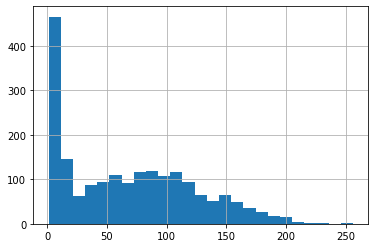

In [10]:
### exploring length of speech segments ###

# getting word counts of each speech
df['word_count'] = (df['speech'].str.count(' ') + 1)

# visualizing in a histogram
df['word_count'].hist(bins = 25)

A lot of these speeches have small word counts (<20). Intuition tells us that these short speeches may be parts of speeches that do not have much meaning. For example, simple yes or no answers and greetings or salutations. We will look at them more closely and filter if needed.

In [11]:
### exploring low word count speeches ###

# creating mask
mask = (df['word_count'] <= 10)

# applying mask
df[mask]['speech']

10                                 Im not.
34                               30 second-
52                        70 is the new 50.
55                   George, George, can I

57                       George, can I say

                       ...                 
5305    Im running because so many people-
5307    Just continue [inaudible 00:46:39].
5320                    Had, in fact, that-
5322             
 immigration bill passed-
5326               
 now American citizens.
Name: speech, Length: 444, dtype: object

These speeches seem to have no meaning so we will filter them out and then move onto a larger word count.

In [12]:
### filtering speeches based on word counts ###

# filtering
df = df[~mask]

In [13]:
### exploring low word count speeches ###

# creating mask
mask = (df['word_count'] <= 20)

# applying mask
df[mask]['speech']

95      I must confess, I dont get too many newspaper...
156     No. What Ive called for is that incarceration...
211     And again, the overall rate was lower than the...
268     
 Ive got to answer before the question, its...
394     Other than that I like him and he got a love l...
                              ...                        
5235    Well I would say for anybody who ran for presi...
5268    Well the process includes 500 super delegates ...
5280    Secondly, you need someone who can govern. I h...
5289    Well you can join me at mikebloomberg.com too ...
5324    
 there would be 10 
 Six million members woul...
Name: speech, Length: 156, dtype: object

These speeches seem to be more meaningful answers to questions and probably contain insight that we don't want to drop so we will keep them. Something we notice is that apostrophes are encoded oddly. We will try to fix this.

In [14]:
### attempting to add ' ###

# replacing with the copied and pasted character
df['speech'].str.replace('', '\'')

# seeing if it worked
df.iloc[268, :]

debate_name                      January Iowa Democratic Debate Transcript
debate_section                                               Entire Debate
speaker                                                     Pete Buttigieg
speech                   Its just not true that the plan Im proposing...
speaking_time_seconds                                                   24
word_count                                                              75
Name: 545, dtype: object

That didn't work. Let's try with all punctuation.

In [15]:
### removing all punctuation ###

# removing punctuation
for punctuation in string.punctuation:
    df['speech'] = df['speech'].str.replace(punctuation, '')
    
# while we're at it, let's just lowercase everything
df['speech'] = df['speech'].str.lower()

df.iloc[268, :]

debate_name                      January Iowa Democratic Debate Transcript
debate_section                                               Entire Debate
speaker                                                     Pete Buttigieg
speech                   its just not true that the plan im proposing...
speaking_time_seconds                                                   24
word_count                                                              75
Name: 545, dtype: object

This unfortunately did not work. In order to fix this, we will need to go into the csv file and change it there. However, for the sake of analysis, we do not need to worry about these words and can carry onto the analysis. Now let's do a final look at the null values.

In [16]:
### null values ###

# mask
mask = df['speaking_time_seconds'].isna()

# value counts
df[mask]['speaker'].value_counts()

Amy Klobuchar       20
Elizabeth Warren    17
Name: speaker, dtype: int64

Unfortunately, there is nothing more we can do for these null values and we can not impute them because we find the speaking time very important in this analysis so we will have to just drop these values.

In [17]:
### dropping null values ###

df = df.dropna(axis = 0)

Now we will turn numbers into a unique string that we can use to identify that the speaker used a number. This is because numbers are typically associated with facts and it may be a useful insight. Keep in mind that we need the number of whitespaces to only exist between words so we have to be careful with how we use our RegEx to preserve the same whitespace structure.

In [18]:
### converting numbers into a useable string ###

# start of speech
df['speech'] = df['speech'].str.replace('^[0-9]+[\s]', 'numnum ')

# middle of speech
df['speech'] = df['speech'].str.replace('[\s][0-9]+[\s]', ' numnum ')

# end of speech
df['speech'] = df['speech'].str.replace('[\s][0-9]+$', ' numnum')

We are almost ready to do exploratory data analysis (EDA). Before we do so, we will drop the debate section column as it holds no information for us.

In [19]:
### dropping debate section ###

df = df.drop('debate_section', axis = 1)

## Exploratory Data Analysis

The first thing I think of or notice when I listen to speeches is how quickly they are speaking. Let's take a look at how many words the candidates say per minute. 

In [20]:
### words per minute ###

# aggregation
df2 = df.groupby(['speaker']).sum()

# creating minutes and wpm columns
df2['speaking_time_minutes'] = df2['speaking_time_seconds'] / 60
df2['wpm'] = (df2['word_count'] / df2['speaking_time_minutes']).astype(int)

# sorting by wpm
df2 = df2.sort_values(by = ['wpm'])

df2

,speaking_time_seconds,word_count,speaking_time_minutes,wpm
speaker,,,,
Bernie Sanders,8326.0,20691,138.766667,149
Elizabeth Warren,8443.0,23097,140.716667,164
Michael Bloomberg,763.0,2295,12.716667,180
Amy Klobuchar,6822.0,20824,113.700000,183
Pete Buttigieg,7567.0,23260,126.116667,184
Joe Biden,8419.0,26229,140.316667,186
Andrew Yang,3133.0,10132,52.216667,194


Text(0.5, 1.0, 'Words per minute of speakers')

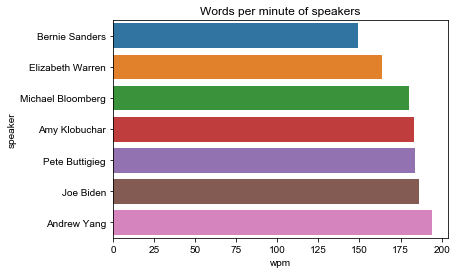

In [21]:
### visualizing wpm ###

sns.barplot(y = df2.index, x = df2['wpm'])
sns.set_style("ticks")
plt.title('Words per minute of speakers')

It can be seen that Bernie Sanders and Elizabeth Warren have the lowest wpms by a good margin. Let's look at another figure taken from the internet. 

![political spectrum](https://i.gyazo.com/9b0575dae4ee951c943e8624f481fb64.png)

We can see from this image that the two most left leaning candidates are Bernie Sanders and Elizabeth Warren, whereas the remaining candidates are all close together on the right. Perhaps where you are on the political spectrum affects your wpm. Let's keep exploring! How about how many words the candidates use per speech?

Text(0, 0.5, 'Speaker')

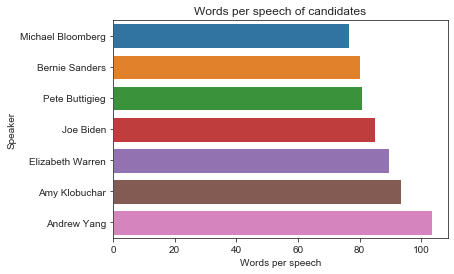

In [22]:
speaker_counts = df['speaker'].value_counts()
wps = df2['word_count'] / speaker_counts
wps = wps.sort_values()

sns.barplot(y = wps.index, x = wps)
plt.title('Words per speech of candidates')
plt.xlabel('Words per speech')
plt.ylabel('Speaker')

Here we see a fairly standard set of words per speech distribution, with Michael Bloomberg having the least words which may be due to his inexperience as a speaker (being new to the political scene). Andrew Yang on the other hand, has the most words per speech which may be due to his supposed small amount of speaking time given in debates. He may feel the need to speak as much as possible each time he is given time to speak. This also aligns with his speaking speed. 

We can note that this assumes that the amount of speaking time Andrew Yang is given being low is true. However, we have the data and we do not just blindly follow assumptions. Let's see for ourselves how this assumption holds!

Text(0.5, 0, 'Number of speeches')

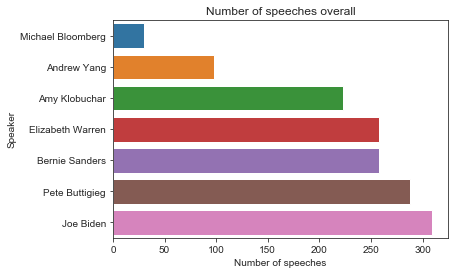

In [23]:
### is Andrew Yang's speaking time less than that of other candidates? ###

# how many times the candidates spoke overall
count_speech = df['speaker'].value_counts()
count_speech = count_speech.sort_values()

sns.barplot(x = count_speech, y = count_speech.index)
plt.title('Number of speeches overall')
plt.ylabel('Speaker')
plt.xlabel('Number of speeches')

First we note that Andrew Yang has the least amount of speeches aside from Michael Bloomberg who has only gone through a single debate. Let's see how Andrew Yang's number of speeches compare to other candidates in each debate.

Text(0.5, 1.0, 'Number of speeches per debate of candidates')

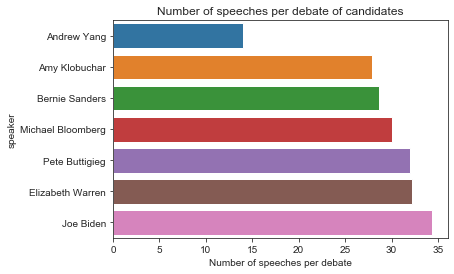

In [24]:
### is Andrew Yang's speaking time less than that of other candidates? ###

# how many times the candidates spoke in each debate
spd = df.groupby(['debate_name', 'speaker']).count()['speech'].groupby('speaker').mean().sort_values()

sns.barplot(x = spd, y = spd.index)
plt.xlabel('Number of speeches per debate')
plt.title('Number of speeches per debate of candidates')

It seems quite clear that Andrew Yang has been given the floor to speak the least amount of times compared to any of the candidates. This is quite significant as well. Finally, let's see how much time the candidates get to investigate further.

Text(0.5, 0, 'Time (min)')

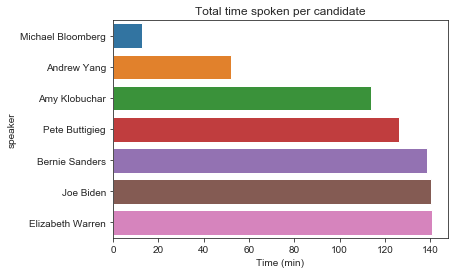

In [25]:
### how much time does every candidate receive? ###

# how much time each candidate meaningfully spoke for
total_time = df.groupby('speaker').sum()['speaking_time_seconds'] / 60
total_time = total_time.sort_values()

sns.barplot(y = total_time.index, x = total_time)
plt.title('Total time spoken per candidate')
plt.xlabel('Time (min)')

Although we see a possibility that Andrew Yang is underrepresented in time, this is an overall sum of time so we need to look at time spoken per debate. We do note that Michael Bloomberg has the least amount of time spoken since he has only participated in one debate. 

Text(0.5, 0, 'Time (min)')

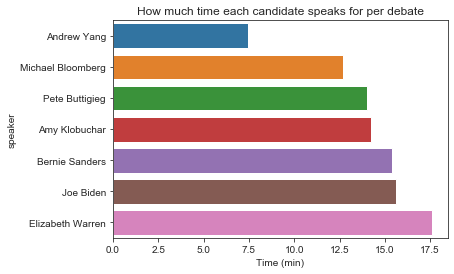

In [26]:
### how much time is Andrew Yang given to speak? ###

# how much time does each candidate speak for per debate
tpd = df.groupby(['debate_name', 'speaker']).sum()['speaking_time_seconds'] / 60
tpd = tpd.groupby('speaker').mean().sort_values()

sns.barplot(y = tpd.index, x = tpd)
plt.title('How much time each candidate speaks for per debate')
plt.xlabel('Time (min)')

Now we can see that Andrew Yang clearly has been given a very little amount of speaking opportunities both in the amount of questions given to him as well as the amount of time he has been given. 

## Feature Extraction

Now that we've done our preliminary EDA, let's start analyzing the actual speeches and extract some features.

In [27]:
### join all speeches for each candidate ###

df3 = df.groupby('speaker')['speech'].apply(lambda x: ' '.join(x))
word_count = df3.apply(len)

df3

speaker
Amy Klobuchar        bernie and i work together all the time but i ...
Andrew Yang          first let me say america its great to be back...
Bernie Sanders       because donald trump lies all the time it does...
Elizabeth Warren     oh bernie and i have been friends for a long t...
Joe Biden            oh they didnt miss anything its a long race ...
Michael Bloomberg    i dont think theres any chance of the senato...
Pete Buttigieg       im not interested in the labels im not inter...
Name: speech, dtype: object

In [28]:
### feature extraction ###

# storing index
df3_index = df3.index

# setting stopwords
stop_words = set(stopwords.words('english'))

# vectorizing speeches (we keep all words since we want to see what makes candidates unique)
vectorizer = CountVectorizer(stop_words = stop_words, ngram_range = (1, 3))
vectorizer.fit(df3)
df3 = vectorizer.transform(df3).todense()

# bag of words
feature_names = vectorizer.get_feature_names()

# converting vectorization into dataframe
df3 = pd.DataFrame(data = df3, columns = feature_names, index = df3_index)

df3

,000,000 people,000 people go,09,09 testified,09 testified gave,10,10 bucks,10 bucks hour,100s,...,zip code prek,zip code yang2020com,zone,zone american,zone american president,zone make,zone make sure,zuckerberg,zuckerberg testified,zuckerberg testified congress
speaker,,,,,,,,,,,,,,,,,,,,,
Amy Klobuchar,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Andrew Yang,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,1,1,1
Bernie Sanders,1,1,1,0,0,0,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
Elizabeth Warren,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Joe Biden,0,0,0,0,0,0,0,0,0,0,...,1,0,1,0,0,1,1,0,0,0
Michael Bloomberg,0,0,0,1,1,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Pete Buttigieg,0,0,0,0,0,0,0,0,0,0,...,0,0,1,1,1,0,0,0,0,0


In [29]:
### scaling ###

# transposing dataframe
df3 = df3.transpose()

# MinMaxScaler
scaler = MinMaxScaler()
scaler.fit(df3)
df3 = scaler.transform(df3)

# converting back to dataframe
df3 = pd.DataFrame(data = df3, columns = df3_index, index = feature_names)

df3.head()

speaker,Amy Klobuchar,Andrew Yang,Bernie Sanders,Elizabeth Warren,Joe Biden,Michael Bloomberg,Pete Buttigieg
000,0.0,0.0,0.004016,0.0,0.0,0.000000,0.0
000 people,0.0,0.0,0.004016,0.0,0.0,0.000000,0.0
000 people go,0.0,0.0,0.004016,0.0,0.0,0.000000,0.0
09,0.0,0.0,0.000000,0.0,0.0,0.043478,0.0
09 testified,0.0,0.0,0.000000,0.0,0.0,0.043478,0.0


Now we have a scaled count of the words spoken by each candidate during the debates. We can now start doing some simple NLP analysis. 

In [30]:
### top words spoken ###

for candidate in df3.columns:
    
    df_candidate = df3[candidate]
    df_candidate = df_candidate.sort_values(ascending = False)
    bag_candidate = df_candidate.index.tolist()
    top_words = bag_candidate[:10]
    print(candidate, "'s top words are'", top_words)

Amy Klobuchar 's top words are' ['think', 'people', 'numnum', 'president', 'one', 'going', 'get', 'would', 'said', 'want']
Andrew Yang 's top words are' ['numnum', 'people', 'would', 'country', 'american', 'know', 'us', 'right', 'going', 'trump']
Bernie Sanders 's top words are' ['numnum', 'people', 'country', 'got', 'going', 'healthcare', 'right', 'american', 'think', 'trump']
Elizabeth Warren 's top words are' ['people', 'numnum', 'need', 'going', 'get', 'america', 'want', 'make', 'every', 'one']
Joe Biden 's top words are' ['numnum', 'fact', 'going', 'people', 'get', 'would', 'one', 'president', 'make', 'said']
Michael Bloomberg 's top words are' ['numnum', 'get', 'people', 'city', 'going', 'trump', 'go', 'well', 'new', 'make']
Pete Buttigieg 's top words are' ['president', 'numnum', 'people', 'going', 'american', 'right', 'us', 'country', 'like', 'one']


Although we are not experts on politics, we can make some potential insights:
* Amy Klobuchar's top word is "think" which may indicate that she doesn't speak with as much confidence
* "numnum" appears in every candidate's top words which makes sense as numbers relate to facts
* Bernie Sanders is the only candidate with "healthcare" in their top words which relates to his strong push for medicare
* Michael Bloomberg is the only candidate with "city" in their top words which may indicate a narrow scope
* Pete Buttigieg is the only candidate with "like" in their top words which may indicate poor speaking skills
* Elizabeth Warren is the only candidate without "president/Trump" in their top words which may indicate that she speaks about her personal political agenda instead of attacking Trump

## Topic Modelling

Using GenSim, we will now try to extract some topics from the debates.

In [31]:
### tokenizing speeches ###

# extracting speeches only
df4 = df['speech']
df4 = df4.reset_index(drop = True)
df4 = df4.str.replace('numnum', '')

# tokenizing speeches
for i in range(len(df4)):
    df4[i] = preprocess_string(df4[i])

df4

0       [didnt, miss, it, long, race, took, hit, iow...
1       [know, regard, senat, sander, presid, want, si...
2       [donald, trump, li, time, doesnt, matter, don...
3       [believ, wai, beat, trump, have, largest, vote...
4       [that, true, that, disappoint, think, probab...
                              ...                        
1459    [lastli, think, it, import, dai, deal, send, ...
1460                                    [million, member]
1461    [unfortun, rulac, group, latino, group, saw, h...
1462    [dont, agre, think, todai, major, countri, ea...
1463    [line, real, chang, take, place, take, place, ...
Name: speech, Length: 1464, dtype: object

In [32]:
### creating corpus ###

# dictionary
dictionary = corpora.Dictionary(df4)

# corpus
corpus = [dictionary.doc2bow(text) for text in df4]

In [33]:
### tfidf vectorization and LDA ###

# tfidf fitting
tfidf = models.TfidfModel(corpus)

# transformation onto corpus
tfidf = tfidf[corpus]

# LDA
lda = models.LdaMulticore(tfidf, num_topics = 10, id2word = dictionary)

In [34]:
### topic modelling ###

lda.show_topics()

[(0,
  '0.004*"that\x92" + 0.003*"countri" + 0.003*"presid" + 0.003*"come" + 0.003*"trump" + 0.003*"chang" + 0.002*"peopl" + 0.002*"american" + 0.002*"wai" + 0.002*"thing"'),
 (1,
  '0.003*"plan" + 0.003*"tax" + 0.003*"need" + 0.003*"peopl" + 0.003*"american" + 0.003*"school" + 0.003*"want" + 0.003*"don\x92t" + 0.003*"fact" + 0.003*"it\x92"'),
 (2,
  '0.003*"that\x92" + 0.003*"peopl" + 0.003*"state" + 0.003*"think" + 0.003*"year" + 0.003*"need" + 0.003*"tell" + 0.003*"go" + 0.003*"presid" + 0.003*"healthcar"'),
 (3,
  '0.004*"want" + 0.003*"peopl" + 0.003*"need" + 0.003*"america" + 0.003*"year" + 0.003*"presid" + 0.003*"pai" + 0.003*"go" + 0.003*"think" + 0.002*"healthcar"'),
 (4,
  '0.003*"think" + 0.003*"presid" + 0.002*"got" + 0.002*"medicar" + 0.002*"know" + 0.002*"crosstalk" + 0.002*"peopl" + 0.002*"elect" + 0.002*"year" + 0.002*"afford"'),
 (5,
  '0.003*"go" + 0.003*"know" + 0.003*"think" + 0.003*"peopl" + 0.003*"talk" + 0.003*"want" + 0.003*"don\x92t" + 0.002*"right" + 0.002*"pr

It is hard to make sense of some of the topics since we did not filter through nouns but here are some of the topics we are able to decipher:
* education costs
* healthcare (insurance and costs)
* republican control of president and senate
* the president

If we are to properly model topics in the future, we would need to filter the words better.

## Conclusion

We have started by wondering what made certain people great at getting their message across but ended finding insights from a variety of less related topics:
* candidate Andrew Yang is severely underrepresented in debates both in opportunities to speak, and time given to speak
* left leaning candidates seem to speak slower
* the top words spoken of each candidate might be indicative of their speaking style and their message/agenda
* debates focus on leadership, and the costs of healthcare/education

In the future, to improve our analysis, we would like to:
* use the final set of debates to complete the analysis
* compare to Republican candidate speeches (most likely Trump)
* tailor stop words for a deeper analysis (e.g. keeping personal pronouns to see if candidates speak about themselves vs. others)
* use only nouns for LDA to better model topics